In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

# Dataset

In [5]:
# Read samples.
samples = pd.read_csv('../data/processed/sb/samples.txt', sep='\t')

# Read IM-Fusion insertions, selecting only insertions that are supported
# by at least two reads (as we did for the CTG test).
insertions_rna = (pd.read_csv('../data/processed/sb/star/insertions.txt',
                              dtype={'seqname': str}, sep='\t')
                    .query('support >= 2'))

# Read ShearSplink insertions.
insertions_dna = (pd.read_csv('../data/external/shear_splink/insertions.rbm.txt', 
                              dtype={'chromosome': str, 
                                     'position': int,
                                     'strand': int, 
                                     'support': int,
                                     'depth': int,
                                     'depth_unique': int}, sep='\t')
                    .rename(columns={'chromosome': 'seqname'}))

name_map = dict(zip(samples['short_name'], samples['sample']))
insertions_dna['sample'] = insertions_dna['sample'].map(name_map)

# Annotating matches

In [6]:
from nbsupport import match, util
    
# Match RNA to DNA insertions.
matches = match.match_rnaseq_insertions(
    insertions_rna, insertions_dna, keep_unmatched=True)

# Drop matches without gene and matches for novel transcripts.
matches = matches.ix[~(matches['gene_id'].isnull() | 
                       matches['gene_id'].str.startswith('STRG'))]

# Annotate matches.
gtf_path = '../data/external/ensembl/Mus_musculus.GRCm38.76.gtf.gz'
genes = util.read_gtf_genes(gtf_path).set_index('id')

matches = (
    matches.pipe(match.annotate_rna_info, rna_insertions=insertions_rna)
           .pipe(match.annotate_dna_info, dna_insertions=insertions_dna)
           .pipe(match.annotate_dna_gene_distance, genes=genes)
           .pipe(match.annotate_dna_gene_position, genes=genes)
           .pipe(match.annotate_type))

# Map types to more readable labels.
matches['type'] = matches['type'].map({
    'shared': 'Shared',
    'dna-only': 'ShearSplink-specific',
    'rna-only': 'IM-Fusion-specific'
})

matches.head()

,rna_id,dna_id,gene_id,rna_position,rna_support,dna_position,dna_support,gene_distance,dna_gene_position,type
0,1566_10_11KOU023.INS_14,11KOU023.INS_1,ENSMUSG00000038679,50822104.0,31.0,50807519.0,85.0,0.0,0.351887,Shared
1,1566_10_11KOU023.INS_14,11KOU023.INS_4,ENSMUSG00000038679,50822104.0,31.0,50798595.0,46.0,0.0,0.389747,Shared
2,1566_10_11KOU023.INS_10,11KOU023.INS_3,ENSMUSG00000019907,108240180.0,9.0,108240765.0,48.0,0.0,0.680402,Shared
3,1566_10_11KOU023.INS_18,11KOU023.INS_12,ENSMUSG00000035168,59646873.0,3.0,59687915.0,21.0,0.0,0.324098,Shared
4,1566_10_11KOU023.INS_5,11KOU023.INS_8,ENSMUSG00000022961,91664823.0,2.0,91665867.0,27.0,0.0,0.578951,Shared


In [15]:
# Annotate insertions with match types.
match_types = (matches[['rna_id', 'gene_id', 'type']]
                      .drop_duplicates()
                      .rename(columns={
                          'rna_id': 'id',
                          'type': 'match_type'
                      }))

insertions_rna = pd.merge(insertions_rna, match_types, 
                          on=['id', 'gene_id'], how='left')

# Picking candidates

In [67]:
def _subset_insertions(insertions, gene_name):
    return (insertions.query('gene_name == {!r}'.format(gene_name))
                      .sort_values(['position', 'support'], ascending=[True, False]))

ctgs = (pd.read_csv('../data/processed/sb/star/ctgs.txt', sep='\t')
          .query('de_pvalue <= 0.05'))


with pd.ExcelWriter('../reports/rna_ctg_insertions.xlsx') as excel_file:
    for gene_name in ctgs['gene_name']:
        subset = _subset_insertions(insertions_rna, gene_name=gene_name)
        subset.to_excel(excel_file, sheet_name=gene_name, index=False)

In [57]:
_subset_insertions(insertions_rna, gene_name='Ctnnd1')

,id,seqname,position,strand,support_junction,support_spanning,support,feature_name,feature_strand,feature_type,...,ffpm_junction,ffpm_spanning,gene_id,gene_name,gene_strand,novel_transcript,orientation,sample,transposon_anchor,match_type
227,2049_28_12SKA017.INS_15,2,84615087,1,6,0,6,En2SA,-1,SA,...,0.633490,0.0,ENSMUSG00000034101,Ctnnd1,-1.0,NaN,antisense,2049_28_12SKA017,1541,IM-Fusion-specific
89,1566_7_11KOU012-R5.INS_30,2,84650405,1,9,0,9,En2SA,-1,SA,...,0.452046,0.0,ENSMUSG00000034101,Ctnnd1,-1.0,NaN,antisense,1566_7_11KOU012-R5,1541,Shared
522,2800_48_12SKA108-R3.INS_6,2,84650405,1,2,0,2,En2SA,-1,SA,...,0.185130,0.0,ENSMUSG00000034101,Ctnnd1,-1.0,NaN,antisense,2800_48_12SKA108-R3,1541,Shared


In [58]:
_subset_insertions(insertions_rna, gene_name='Trp53bp2')

,id,seqname,position,strand,support_junction,support_spanning,support,feature_name,feature_strand,feature_type,...,ffpm_junction,ffpm_spanning,gene_id,gene_name,gene_strand,novel_transcript,orientation,sample,transposon_anchor,match_type
721,2800_77_13SKA013-L3.INS_15,1,182428893,1,6,0,6,SD,1,SD,...,0.420668,0.0,ENSMUSG00000026510,Trp53bp2,1.0,NaN,sense,2800_77_13SKA013-L3,1043,Shared
385,2800_29_12SKA084-L3.INS_4,1,182435435,-1,2,0,2,En2SA,-1,SA,...,0.262525,0.0,ENSMUSG00000026510,Trp53bp2,1.0,NaN,antisense,2800_29_12SKA084-L3,1541,Shared
383,2800_29_12SKA084-L3.INS_5,1,182436897,1,8,0,8,SD,1,SD,...,1.050100,0.0,ENSMUSG00000026510,Trp53bp2,1.0,NaN,sense,2800_29_12SKA084-L3,1043,Shared
345,2800_18_12SKA064-L3.INS_3,1,182442862,-1,2,0,2,En2SA,-1,SA,...,0.268965,0.0,ENSMUSG00000026510,Trp53bp2,1.0,NaN,antisense,2800_18_12SKA064-L3,1541,Shared
692,2800_73_13SKA010-R2.INS_1,1,182446737,1,2,0,2,SA,1,SA,...,0.247065,0.0,ENSMUSG00000026510,Trp53bp2,1.0,NaN,sense,2800_73_13SKA010-R2,420,Shared
120,2049_13_11KOU051-R3.INS_4,1,182448400,1,23,0,23,SD,1,SD,...,1.506165,0.0,ENSMUSG00000026510,Trp53bp2,1.0,NaN,sense,2049_13_11KOU051-R3,1043,Shared
690,2800_73_13SKA010-R2.INS_5,1,182448400,1,22,0,22,SD,1,SD,...,2.717719,0.0,ENSMUSG00000026510,Trp53bp2,1.0,NaN,sense,2800_73_13SKA010-R2,1043,Shared
434,2800_37_12SKA092-L4-L5.INS_3,1,182448400,1,9,0,9,SD,1,SD,...,0.586467,0.0,ENSMUSG00000026510,Trp53bp2,1.0,NaN,sense,2800_37_12SKA092-L4-L5,1043,Shared
494,2800_43_12SKA102-R3.INS_3,1,182448400,1,7,0,7,SD,1,SD,...,0.491829,0.0,ENSMUSG00000026510,Trp53bp2,1.0,NaN,sense,2800_43_12SKA102-R3,1043,Shared
707,2800_76_13SKA012-L3.INS_6,1,182448400,1,7,0,7,SD,1,SD,...,0.453363,0.0,ENSMUSG00000026510,Trp53bp2,1.0,NaN,sense,2800_76_13SKA012-L3,1043,Shared


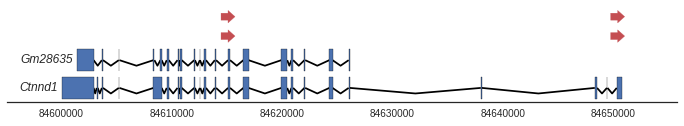

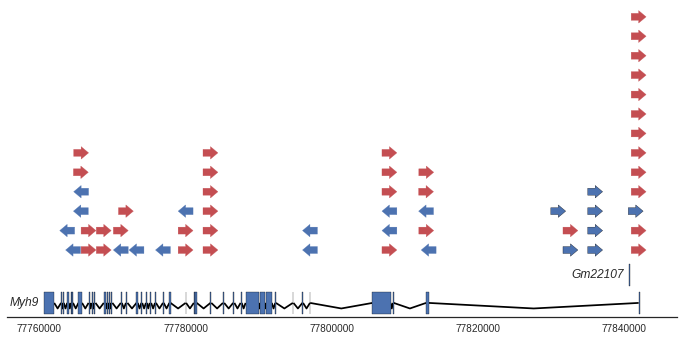

In [46]:
from geneviz.tracks import BiomartTrack, FeatureTrack, plot_tracks
from nbsupport.util import fetch_biomart_genes_mm10


def plot_insertions(insertions,
                    region,
                    padding=None,
                    reverse=False,
                    figsize=(12, None)):
    """Visualizes insertions on gene track."""

    # Insertion track.
    palette = [sns.color_palette()[0], 
               sns.color_palette()[2]]

    ins_data = insertions.rename(columns={'seqname': 'chromosome'})
    width = (region[2] - region[1]) / 40

    feature_track = FeatureTrack.from_position(
        ins_data,
        width=width,
        height=0.25,
        hue='orientation',
        palette=palette,
        hue_order=['sense', 'antisense'])

    # Gene track.
    gene_track = BiomartTrack(
        dataset='mmusculus_gene_ensembl',
        height=0.4,
        collapse='transcript',
        gene_id='gene_name',
        label_kws={'fontsize': 12,
                   'fontstyle': 'italic'})

    # Draw tracks.
    g = plot_tracks(
        [feature_track, gene_track],
        region=region,
        figsize=figsize,
        reverse=reverse,
        padding=padding)

    # Despine axes.
    sns.despine(ax=g.axes[0], left=True, bottom=True)
    sns.despine(ax=g.axes[1], left=True, bottom=False)

    # Reduce spacing between tracks.
    plt.subplots_adjust(hspace=0.01)

    return g


# Fetch genes.
genes = fetch_biomart_genes_mm10()

# Build region lookup.
region_iter = ((tup.chromosome, tup.start, tup.end)
               for tup in genes.itertuples())

gene_regions = dict(zip(genes['gene_name'], region_iter))

# Plot insertions.
plot_insertions(insertions, region=gene_regions['Ctnnd1'], padding=(5000, 5000))
plot_insertions(insertions, region=gene_regions['Myh9'], padding=(5000, 5000));

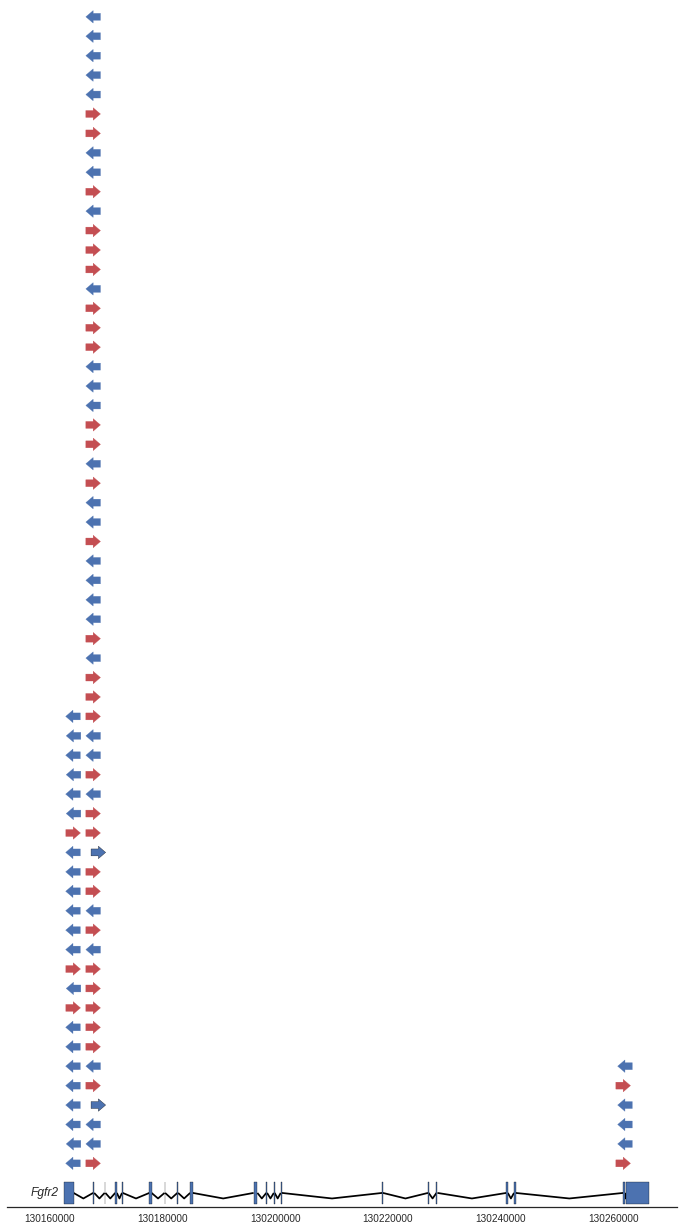

In [50]:
plot_insertions(insertions, region=('7', 130162451, 130266263), padding=(10000, 5000));